<a href="https://colab.research.google.com/github/yanglinjing/vmor/blob/master/Bank_customer_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Loan Data

In [1]:
pip install mysql-connector

     |████████████████████████████████| 11.9MB 100kB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=f609962b1b3f4b5ae2bc766ff48af02c1c5fdfd6dbedc1a8be6fdd1e92699d86
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


In [2]:
# mySQL
import mysql.connector

import numpy as np
import pandas as pd

# PCA and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import datetime as dt
#from dateutil.relativedelta import *

In [0]:
my_color = ['#42bff4', '#f9ace9']

# Step 1： Import Data

In [0]:
# Import data from mySQL
db = mysql.connector.connect(user='Linjing', 
                             password='Linjing',
                             host='119.9.52.51',
                             database='bankloan')

In [0]:
# Create a Cursor object. It will let
#  you execute all the queries you need
cur = db.cursor()

In [0]:
cur.execute('SELECT * \
             FROM defaultloan')

In [0]:
# Put data into df
table = cur.fetchall()
df_raw = pd.DataFrame(table)

In [0]:
# Get column names 
num_cols = len(cur.description)
cols = [i[0] for i in cur.description]

# Change column names of df
df_raw.columns = cols

In [0]:
db.close()

# Step 2: Proprecessing Data


## Step 2.1 Observing Data

In [0]:
df = df_raw.copy()

In [12]:
df.shape

(276546, 50)

In [13]:
df.sample(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Total Term,Deposit_Percent,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No of Days in Arrears,DefaultAmount,DefaultDate,MonthsToDefault,Recent Default_Default Date,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
226722,288864,61186399,L881806703,1005855,PaidInFull,24/06/2007,2/07/2007,2007H2,16/07/2007,1230,123,1107,12,0.1,12,0,CC,12,Mth,92.25,"1,107.00",0.00,917.2,0.134399995,148.78,23.75,0,0,172.53,0.00,172.53,0.155853659,16/07/2008,0,0,0,0,,,,0.00,0.00,,5114,3/05/1982,30112867,MICHAEL HILL JEWELLER HOLLYWOOD PLAZA (461),Jewellery,No,No
24649,24650,60695805,L60695805,FURN,PaidInFull,19/08/2006,24/08/2006,2006H2,13/09/2006,2220,555,1665,12,0.25,12,0,CC,12,Mth,138.75,"1,665.00",0.00,1479.4,0.085699998,142.69,26,0,0,168.69,0.00,168.69,0.101315315,13/09/2007,0,0,0,0,,,,0.00,0.00,,6029,8/09/1975,90100029,ARCHIPELAGO LIVING,Furniture / Bedding New,No,No
41308,41309,60800390,L60800390,SHUTTER,PaidInFull,22/11/2005,1/01/2006,2006H1,10/01/2006,3000,600,2400,12,0.2,12,0,CC,26,FN,92.29349331,"2,400.00",0.00,2152.2,0.082999997,199.19,26,0,0,225.19,0.00,225.19,0.093829167,10/01/2007,0,0,0,0,,,,0.00,0.00,,5095,10/02/1986,30107778,GOTTA GETTA GROUP,Roofing / Shutters / Gutters,Yes,Yes


## Step 2.2 Convert Data Type

In [0]:
# convert object to datetime

column_date = ['Application_Date', 
               'Entry_Date', 
               'Fist Installment Date', 
               'Expected Contract End Date', 
               'DefaultDate', 
               'Recent Default_Default Date',
               #'Recent Default_Cure Date',
               'Consumer Year of Birth']

for column in column_date:
  df[column] = pd.to_datetime(df[column])

In [15]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Total Term,Deposit_Percent,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No of Days in Arrears,DefaultAmount,DefaultDate,MonthsToDefault,Recent Default_Default Date,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600,48,0.278254931,48,0,Bank,48,Mth,54.16666667,"2,600.00",0.00,1965.3,0.221900001,576.93,0,0,0,576.93,0.00,576.93,0.221896154,2010-11-26,0,0,0,0,NaT,,NaT,0.00,0.00,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,Yes,Yes


In [0]:
# convert object to float

column_num = ['Purchase Amt', 'Deposit Amt', 'Financed Amt', 
              'Total Term', 'Deposit_Percent', 'Term_Run',
              'Term_Remaining', 'Total No Of Payments',
              'Instalment Amt', 'Total Payments Received',
              'Total Balance Outstanding', 'Amt Paid To Merchant_nettofmerchfeesandGST',
              'Gtee Rate', 'Gtee Charges', 'Est Fees',
              'Proc Fees', 'Other Fees', 'Total Merchant Charges',
              'Total Consumer Charges', 'Total Charges',
              'Effective Billing Rate', 'No Of Days In Default',
              'Arrears Amount', 'No of Days in Arrears',
              'DefaultAmount', 'MonthsToDefault',
              'Recent Default_Default Amt',
              'Recent Default_Recov Amt']

for column in column_num:

  # Remove thousand separator 
  df[column] = df[column].str.replace(',', '')

  # Nan / NaT
  df[column] = df[column].str.replace('NaT', '')
  df[column] = df[column].str.replace('NaN', '')

  # convert string to numeric
  df[column] = pd.to_numeric(df[column])


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276546 entries, 0 to 276545
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Id                                          276546 non-null  int64         
 1   Contract_Number                             276546 non-null  object        
 2   Consumer_ID                                 276546 non-null  object        
 3   Product                                     276546 non-null  object        
 4   Contract_Status                             276546 non-null  object        
 5   Application_Date                            276546 non-null  datetime64[ns]
 6   Entry_Date                                  276546 non-null  datetime64[ns]
 7   StartHalf                                   276546 non-null  object        
 8   Fist Installment Date                       276546 non-null  datetime64[ns

## Step 2.3 Missing Values

### Step 2.3.1 Columns


In [18]:
# Calculate the percentage of missing values of each column
missing = df.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

print(f"{len(missing)} out of {df.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")

7 out of 50 columns contain missing values, from 0.0% to 95.97%.


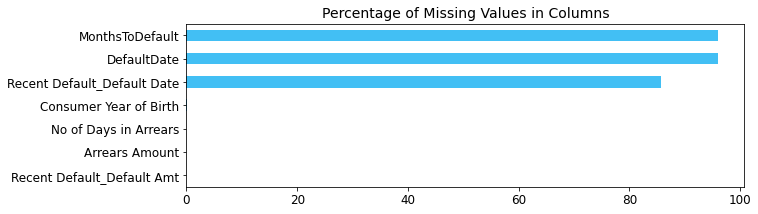

In [19]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 3), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [0]:
# Remove the outlier columns from the dataset / feature summary. 

# columns have more than 80% missing values
missing_80 = missing[missing >80]

# Drop columns that contain 20% missing values
for col in missing_80.index:
  
  # Dataset
  df.drop(col, axis = 1, inplace = True)


In [21]:
df.shape

(276546, 47)

### Step 2.3.2 Rows


In [0]:
# How much data is missing in each row of the dataset?
missing_r = df.isnull().sum(axis=1)

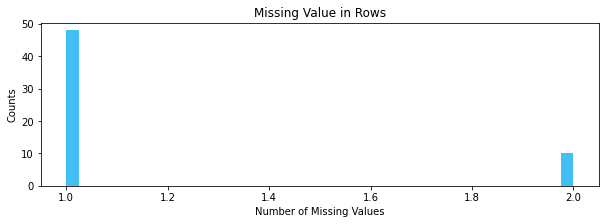

In [23]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,3), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

## Step 2.4 Calculate Percentage

In [0]:
# arrears and all kinds of fees
fees = ['Arrears Amount',
        'DefaultAmount',
        'Recent Default_Default Amt',
        'Recent Default_Recov Amt',
        'Amt Paid To Merchant_nettofmerchfeesandGST',
        'Est Fees',
        'Proc Fees',
        'Other Fees',
        'Total Merchant Charges',
        'Total Consumer Charges'
        ]

In [0]:
fees = ['Arrears Amount',
        'DefaultAmount',
        'Recent Default_Default Amt',
        'Recent Default_Recov Amt',
        'Amt Paid To Merchant_nettofmerchfeesandGST',
        'Est Fees',
        'Proc Fees',
        'Other Fees',
        'Total Merchant Charges',
        'Total Consumer Charges'
        ]

In [26]:
df.sample(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Total Term,Deposit_Percent,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
254224,316366,61261452,L61261452,PIANO,PaidInFull,2007-09-24,2007-01-10,2007H2,2007-11-10,1649.0,412.25,1236.75,12,0.25,12,0,CC,12,Mth,103.0625,1236.75,0.0,1086.8,0.0859,106.23,30.0,0,0.0,136.23,0.0,136.23,0.110152,2008-11-10,0,0.0,0.0,0.0,0.0,0.0,,2232,1965-08-23,30100493,SHIRE MUSIC CENTRE,Musical Instruments,No,No


In [0]:
# convert amount to percentage
for fee in fees:
  df[fee] = df[fee] / df['Financed Amt']

In [0]:
# rename columns (amount -> percentage)
df.rename(columns={'Arrears Amount': 'arrear_p',
                   'DefaultAmount': 'default_p',
                    'Recent Default_Default Amt': 'recent_default_default_p',
                    'Recent Default_Recov Amt': 'recent_default_recov_p',
                    'Amt Paid To Merchant_nettofmerchfeesandGST': 'gst_p',
                    'Est Fees': 'est_fee_p',
                    'Other Fees': 'other_fee_p',
                    'Total Merchant Charges': 'total_merchant_charge_p',
                    'Total Consumer Charges': 'total_consumer_charges'                
                   }, 
          inplace=True)

## Step 2.5 Rename Columns

In [0]:
df.rename(columns={'Financed Amt': 'financed_amt', 
                   'Deposit_Percent': 'deposit_percent',
                   'Payment Type': 'payment_type',
                   'Instalment Amt': 'instalment_amt',
                   'Gtee Rate': 'gtee_p',
                   'Effective Billing Rate': 'effective_billing_rate',
                   'No Of Days In Default': 'days_default',
                   'No Of Days In Arrears': 'days_arrears',
                   'MonthsToDefault': 'mth_to_default'              
                   }, 
          inplace=True)

## Step 2.6 Re-Encode Non-Numeric Binary Variable

Re-encode: 2-level obj

`Freq`

* FN: Fortnightly: 0
* Mth: Monthly: 1

`payment_type`

* Bank: 0
* CC: 1

`Homowner Ind`, `Homowner Consumer`
* Yes: 1
* No: 0

In [0]:
# Re-encode: 2-level obj
df['Freq'] = df['Freq'].map({'FN': 0, 'Mth': 1})
df['payment_type'] = df['payment_type'].map({'Bank': 0, 'CC': 1})
df['Homowner Ind'] = df['Homowner Ind'].map({'Yes':1, 'No':0})
df['Homowner Consumer'] = df['Homowner Consumer'].map({'Yes':1, 'No':0})

In [31]:
df.sample(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
212146,274288,61149596,L61149596,RING,PaidInFull,2007-08-22,2007-08-28,2007H2,2007-09-22,1449.0,144.9,1304.1,12,0.100000,12,0,0,26,0,50.149977,1304.1,0.0,0.849705,0.1190,155.18,0.017637,0.0,0.0,0.136631,0.061345,258.18,0.197976,2008-09-22,0,0.0,0.0,0.0,0.615444,0.615444,39514,4680,1971-10-31,30113885,PROUDS JEWELLERS GLADSTONE (427),Jewellery,0,0
44943,44944,60814252,L60814252,VACUUM,PaidInFull,2006-07-28,2006-08-08,2006H2,2006-11-09,1100.0,300.0,800.0,6,0.272727,6,0,0,6,1,133.333333,800.0,0.0,0.910500,0.0563,45.04,0.025000,0.0,0.0,0.081300,0.000000,65.04,0.081300,2007-11-03,0,0.0,0.0,0.0,0.000000,0.000000,,6026,1967-08-22,30104047,GODFREYS - JOONDALUP,Vacuums,0,0
43578,43579,60809317,L60809317,BBQ,PaidInFull,2006-06-22,2006-06-27,2006H1,2006-07-21,3168.0,790.0,2378.0,12,0.249369,12,0,0,12,1,198.166667,2378.0,0.0,0.924138,0.0580,137.92,0.010934,0.0,0.0,0.068932,0.000000,163.92,0.068932,2007-07-21,0,0.0,0.0,0.0,0.000000,0.000000,,2525,1950-03-18,30112881,AGL ENERGY SHOP WARRAWONG,Hot Water / Gas,1,1


## Step 2.7 Categorical Variable with more than 2 types

In [32]:
df['Contract_Status'].value_counts()

PaidInFull    264847
Default        11178
Active           521
Name: Contract_Status, dtype: int64

## Step 2.8 Mark people who have had arrears

Is there anyone who does not have arrears?

In [33]:
# Is there anyone who does not have arrears?

df_no_arrears = df[df['recent_default_default_p'] == 0]

no_arrear_p = df_no_arrears.shape[0] / df.shape[0] * 100

print(f"{df_no_arrears.shape[0]} people do not have arrears, occupying {round(no_arrear_p, 2)}%.")

237019 people do not have arrears, occupying 85.71%.


In [0]:
df['has_arrears'] = df['recent_default_default_p'].apply(lambda x: 1 if x > 0 else 0)

How many people have recovered arrears?

In [35]:
# How many people have recovered arrears?

df_recov = df[df['recent_default_recov_p'] > 0]

recov_p = df_recov.shape[0] / df.shape[0] * 100

print(f'{df_recov.shape[0]} people have recovered arrears, occupying {round(recov_p, 2)}%.')

32146 people have recovered arrears, occupying 11.62%.


How many people have recovered arrears in full?

In [36]:
# How many people have recovered arrears in full?

df_recov_infull = df[df['recent_default_recov_p']==1]

recov_infull_p = df_recov_infull.shape[0] / df.shape[0] * 100

print(f'{df_recov_infull.shape[0]} people have recovered arrears in full, occupying {round(recov_infull_p, 2)}%.')

700 people have recovered arrears in full, occupying 0.25%.


# Step 3 Exploring Data

## 3.1 Contracts

* How many contracts in total? For each year? For month? - (bar chart)

In [37]:
print(f"The totla number of contracts is {df.shape[0]:,}.")

The totla number of contracts is 276,546.


In [38]:
print(f"The earlist entry date is {df['Entry_Date'].min()}, whereas the latest is {df['Entry_Date'].max()}.")

The earlist entry date is 2006-01-01 00:00:00, whereas the latest is 2007-12-31 00:00:00.


In [0]:
# put Year into new columns
df['entry_y'] = df['Entry_Date'].dt.year
#df['entry_m'] = df['Entry_Date'].dt.month

# put Year and Month into new columns
df['entry_y_m'] = df['Entry_Date'].dt.to_period('M')

In [0]:
def get_agg_df(col, agg_col, method):
  """
  get aggregating result from df

  INPUT:
    col - the column name in df which data will be grouped by
    agg_col - target column that will be aggregrated
    method - method of aggregration, like "count"

  OUTPUT:
     x - the column that was grouped by
     y - the aggregating result
     result - df with agg results
  """

  # get agg number, return a df
  result = df.groupby(col).agg({agg_col: method})

  # put total number into y
  y = result[agg_col]

  # put index into a new column (index was col)
  result[col] = result.index
  result = result.reset_index(drop = True) # change index to 0,1,2...
  x = result[col]

  return x, y, result

In [0]:
def draw_basic_bar_plot(x, y, fig_h, fig_w, title, x_lab, y_lab):
  """
  Draw a basic bar plot

  INPUTS:
     x - the column that was grouped by
     y - the aggregating result
     fig_h, fig_w - size of the figure
     title - plot title
     x_lab, y_lab - x and y lable
  """

  # Import data:
  height = y
  bars = x
  y_pos = np.arange(len(bars))

  # Change the shape of figure
  fig = plt.figure(num=None, figsize=(fig_h, fig_w), dpi=80, facecolor='w', edgecolor='k')

  # Create bars
  plt.bar(y_pos, height, color = my_color[0])
  
  # Create names on the x-axis
  plt.xticks(y_pos, bars, rotation=45)

  # Add title and labels
  fig.suptitle(title, fontsize = 20)
  plt.xlabel(x_lab, fontsize = 18)
  plt.ylabel(y_lab, fontsize = 16)

  # Show graphic
  plt.show()

In [0]:
x, y, r = get_agg_df('entry_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 10, 6, 'Contracts in Each Month in 2006 - 2007', 'Month', 'Number of Contracts')

In [44]:
x, y, r = get_agg_df('entry_y', 'Contract_Number', "count")
r

,Contract_Number,entry_y
0,132791,2006
1,143755,2007


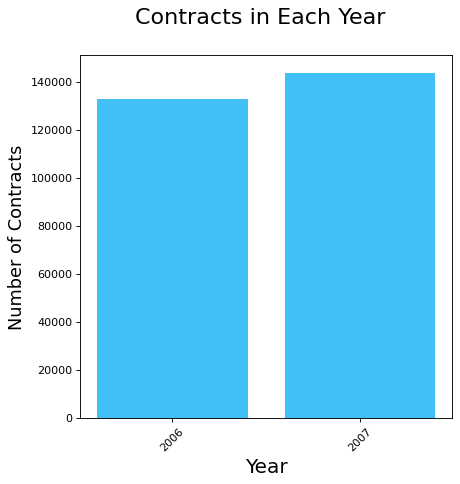

In [45]:
draw_basic_bar_plot(x, y, 6, 6, 'Contracts in Each Year', 'Year', 'Number of Contracts')

## 3.2 Consumers

 

### 3.2.1 How many consumers in total?

In [47]:
df['Consumer_ID'].value_counts()

L61112156    10
L60028728     7
L50019007     7
L50016784     7
L60832218     7
             ..
L60950296     1
L60317105     1
L61077777     1
L60745207     1
L60849863     1
Name: Consumer_ID, Length: 255718, dtype: int64

## 3.2.2 How about the increased rate/number of consumers for each year? For month?

In [48]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,has_arrears,entry_y,entry_y_m
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,0,2006,2006-01


In [0]:
# put Year into new columns
df['app_y'] = df['Application_Date'].dt.year

# put Year and Month into new columns
df['app_y_m'] = df['Application_Date'].dt.to_period('M')

In [50]:
x, y, r = get_agg_df('app_y', 'Consumer_ID', 'count')
r

,Consumer_ID,app_y
0,1,2004
1,8738,2005
2,133882,2006
3,133925,2007


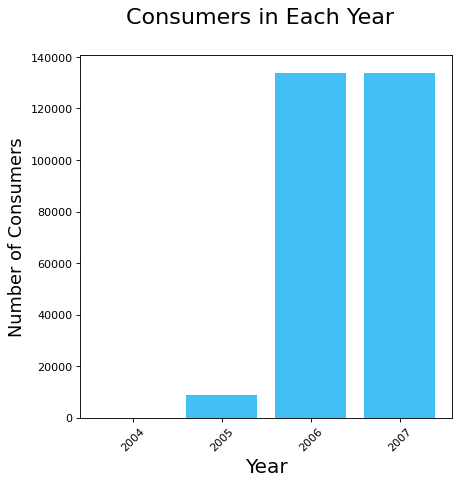

In [51]:
draw_basic_bar_plot(x, y, 6, 6, 'Consumers in Each Year', 'Year', 'Number of Consumers')

In [0]:
x, y, r = get_agg_df('app_y_m', 'Consumer_ID', 'count')

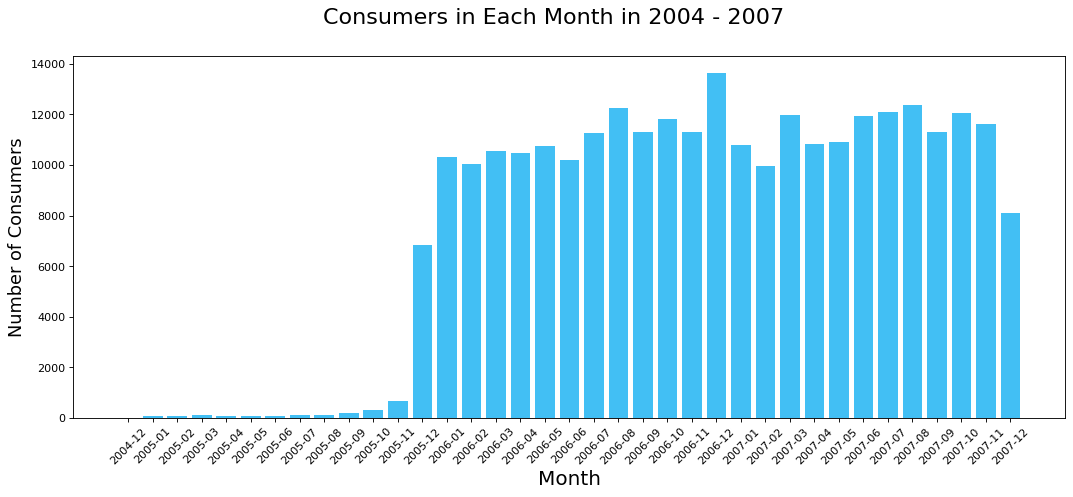

In [53]:
draw_basic_bar_plot(x, y, 16, 6, 'Consumers in Each Month in 2004 - 2007', 'Month', 'Number of Consumers')

In [0]:
# calculate the increased rate of each month
r['consumer_increased_rate'] = r['Consumer_ID'].pct_change()

In [0]:
r.drop(r.index[[0,1]], inplace=True)

# 3.3 Products

How many products in total? What are the percentages for each product?


In [0]:
def count_types(col):
  # calculate the number of product types
  new_df = df[col].value_counts()

  # put the value_counts() output into df
  new_df = new_df.rename_axis('type').reset_index(name='counts')

  # use column as index
  new_df.set_index('type', inplace=True)

  return new_df


In [0]:
product_df = count_types('Product')

In [0]:
# calculate the number of product types
product_df = df['Product'].value_counts()

# put the value_counts() output into df
product_df = product_df.rename_axis('product_type').reset_index(name='counts')

In [96]:
print(f"There are {product_df.shape[0]:,} kinds of products, \
and {product_df[product_df['counts'] >1000].shape[0]} types \
of them were bought more than 1000 times.")

There are 22,733 kinds of products, and 37 types of them were bought more than 1000 times.


In [0]:
# use column as index
product_df.set_index('product_type', inplace=True)

In [89]:
# build a new df, with types more than 1000
product_df_new = product_df[product_df['counts'] > 1000]

# count the total number of types less than 1000
n = product_df[product_df['counts'] <= 1000].sum()['counts']

# Add a new row in the new df
product_df_new.loc['Other Types'] = [n]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def plot_pct(df):
  df.plot(kind='pie', subplots=True, figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f80c69c4048>],
      dtype=object)

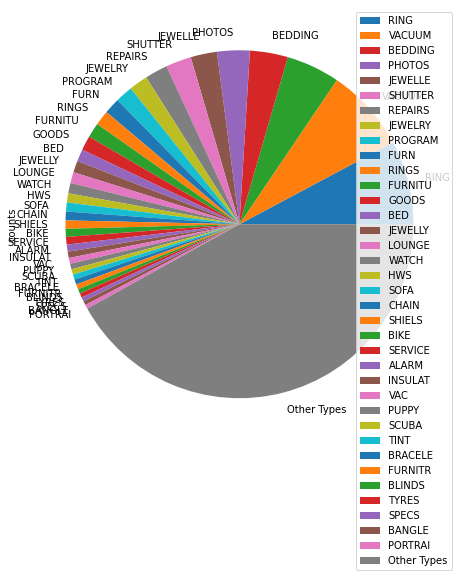

In [90]:
product_df_new.plot(kind='pie', subplots=True, figsize=(16,8))

## 3.4 Contracts

How many types of Contract_status? What are the percentages for every status? (pie chart)

In [99]:
count_types('Contract_Status')

,counts
type,
PaidInFull,264847
Default,11178
Active,521


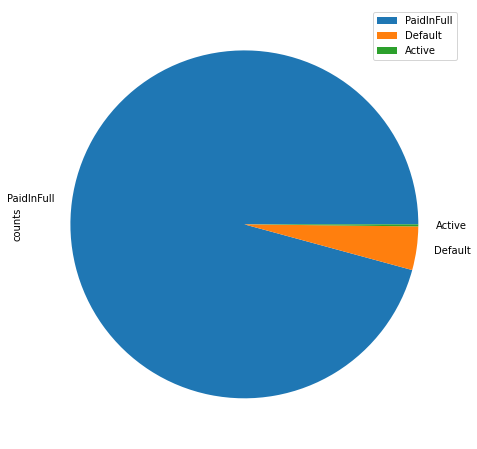

In [105]:
plot_pct(count_types('Contract_Status'))

## 3.7 StartHalf

What are the percentages for each “StartHalf”

In [102]:
count_types('StartHalf')

,counts
type,
2007H2,74589
2007H1,69166
2006H2,68471
2006H1,64320


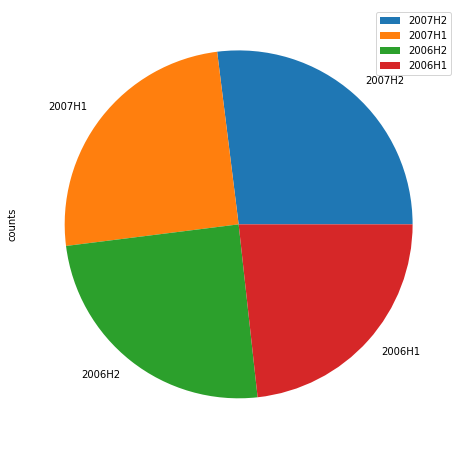

In [106]:
plot_pct(count_types('StartHalf'))

## 3.8 First Installment Date

What are the number and percentages of “First Installment Date" for each month?

In [107]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,has_arrears,entry_y,entry_y_m,app_y,app_y_m
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,0,2006,2006-01,2006,2006-10


In [0]:
# put Year and Month into new columns
df['install_y_m'] = df['Fist Installment Date'].dt.to_period('M')

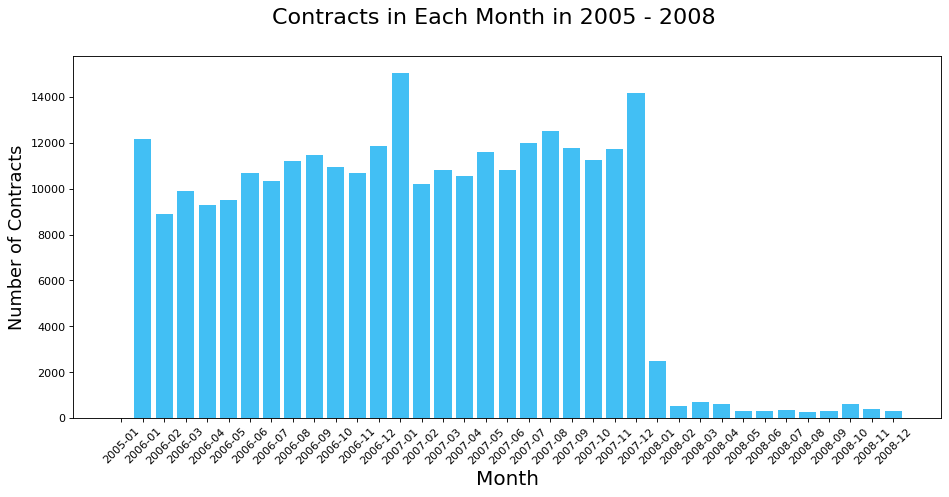

In [111]:
x, y, r = get_agg_df('install_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 14, 6, 'Contracts in Each Month in 2005 - 2008', 'Month', 'Number of Contracts')

## 3.15 Payment Type

What are the types in “payment Types”, and what are the percentages for each “payment type”?

In [112]:
count_types('payment_type')

,counts
type,
0,201989
1,74557


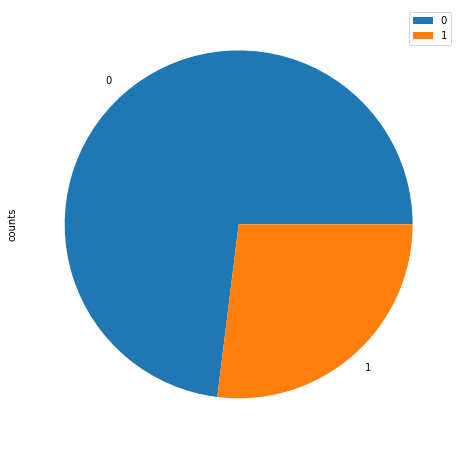

In [113]:
plot_pct(count_types('payment_type'))